# Benign or Malignant Cancer Cells Based on Attributes

<u>_Group Members:_</u>
- Eli Brignac ebrignac@udel.edu
- Jonathan Ma johnma@udel.edu
- Xiaofan Li xiaofan@udel.edu

[Data Set Here](https://www.kaggle.com/datasets/erdemtaha/cancer-data)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import random
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [19]:
#Load the dataset
df = pd.read_csv("Cancer_Data.csv")
# print(df.head())
print(df.shape)

(569, 33)


# The Dataset

569 cancer cells and 33 features to determine whether the cancer cells in our data are benign or malignant. 30 of these 33 features are all numerical features making this problem suitable for a NN. Of these 569 cells, 357 of them (62.74%) are labeled as Benign and 212 of them (37.26%) are Malignant.

Before we begin training our model, we must clean up the data. We start by removing the `id` column as it doesn't provide any useful information. Next, we map the `diagnosis` attribute to 1 for a Malignant tumor and 0 for a Benign Tumor. Finally, we remove a random column titled `Unnamed: 32` as it doesn't provide any useful infromation.

We are left with 569 rows, and 31 columns. 1 column is the diagnosis (ouput value), while the other 30 are the statistics about the tumors (input values).



| Category      | Attribute 1 (Mean)  |  Attribute 2 (SE)  | Attribute 3 (Worst)  |
| -------- | ---------------------- | ---------------------- | ----------------------- |
| Radius   | radius_mean            | radius_se              | radius_worst            |
| Texture  | texture_mean           | texture_se             | texture_worst           |
| Perimeter| perimeter_mean         | perimeter_se           | perimeter_worst         |
| Area     | area_mean              | area_se                | area_worst              |
| Smoothness | smoothness_mean       | smoothness_se          | smoothness_worst        |
| Compactness | compactness_mean     | compactness_se         | compactness_worst       |
| Concavity | concavity_mean         | concavity_se           | concavity_worst         |
| Concave Points | concave points_mean | concave points_se      | concave points_worst    |
| Symmetry | symmetry_mean           | symmetry_se           | symmetry_worst          |
| Fractal Dimension | fractal_dimension_mean | fractal_dimension_se | fractal_dimension_worst |


In [20]:
data = df.drop('id', axis=1)

data['diagnosis'] = df['diagnosis'].map({'M': 1 , 'B':0})
data = data.drop('Unnamed: 32', axis = 1)
print("Shape of Data we are using:",data.shape)
# print(data.head())
#The line below prints the amount of Benign and Malignant tumors in our dataset
#print(df['diagnosis'].value_counts())

Shape of Data we are using: (569, 31)


# Training and Test samples
We are using a 70:30 Train-Test split for our model which is a rather large testing split, but as you will see later, our model has remarkable accuracy so a large testing dataset isn't counter productive.

In [21]:
#Set the Random State for our models, this can be changed or 
random_state = 42
X, y = data.drop('diagnosis', axis=1), data['diagnosis']
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X,y, test_size = .3, random_state = random_state)


#Scale the Training and Testing Data
#This scales all of the data to have a standard deviation of 1 and mean 0
#(Standardizes the data so its a Z score)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


#print(X_train)
#print(y_train)

# Helper Functions

### These function will be used to help plot the data

In [22]:
def plot_loss_curve(mlp, model):
    '''
    mlp = MLPClassifier
    model = mlp.fit(X_train, y_train)
    '''
    add = f"\nFinal Loss Value {model.loss_curve_[-1]}"
    #add += f"\nPercent Accuracy: {round(accuracy,4) * 100}%"
    plt.plot(model.loss_curve_, label='Training loss')
    if mlp.validation_scores_ != None:
        plt.plot(mlp.validation_scores_)
    plt.title('Loss Curve', fontsize = 20)
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)
    plt.legend(fontsize = 16)
    return plt

In [23]:
def plot_learning_curve(model, X, y):
    '''
    model = mlp.fit(X_train, y_train)
    X = The input data
    y = The output data
    '''

    # do 10 fold cross validation (cv = 10)
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes=[.1,.2,.3,.4,.5,.6,.7,.8,.9, 1], cv=10, n_jobs=-1)
    #print(test_scores)
    # Compute the mean and standard deviation of the train and test scores
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.title('Learning Curve (MLP)', fontsize = 20)
    plt.xlabel('Training Examples', fontsize = 20)
    plt.ylabel('Accuracy', fontsize = 20)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color='b')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='b',
             label='Cross-Validation Score')
    plt.legend(loc='best', fontsize = 18)
    return plt
    

In [24]:
def plot_confusion_matrix(cm):
    '''
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    '''
    perc_acc = str(round((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]), 4) * 100)
    classes = ['Malignant', 'Benign']
    # plot confusion matrix with labels
    classes = ['Malignant', 'Benign']
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax, label ="Number of Samples")
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion matrix\nAccuracy ' + perc_acc + "%",
           ylabel='True label',
           xlabel='Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    # add text labels to each box
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            label = ''
            if i == 0 and j == 0:
                label = 'TP'
            elif i == 0 and j == 1:
                label = 'FP'
            elif i == 1 and j == 0:
                label = 'FN'
            else:
                label = 'TN'

            ax.text(j, i, format(label + '\n' + str(cm[i, j]), 's'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 20)

    return plt

    

# Trained on Scaled Data

In [25]:
# Create an MLP object
mlp = MLPClassifier(hidden_layer_sizes=(16,32), max_iter=1000, activation='relu',
                    solver='adam', batch_size = 32, random_state = random_state)

# Train the MLP using the input and output datasets
model = mlp.fit(X_train, y_train)

accuracy = mlp.score(X_test, y_test)
print(f"Accuracy: {accuracy}")
print(f"Percent Accuracy: {round(accuracy,4) * 100}%")

Accuracy: 0.9883040935672515
Percent Accuracy: 98.83%


##### Plot Helpful Metrics

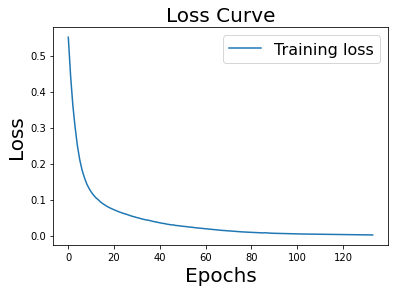

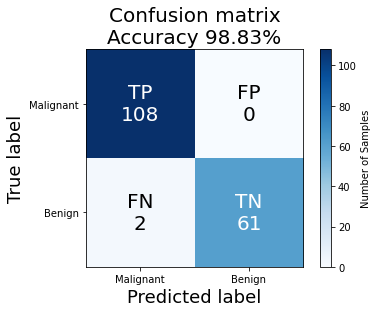

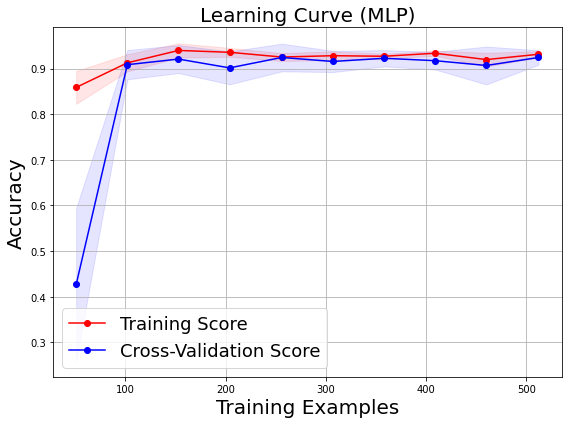

In [26]:
# Plot the training and validation loss
loss_plot = plot_loss_curve(mlp,model)

# Plot Confusion Matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_plot = plot_confusion_matrix(cm)

# # Plot Learning Curve
learn_plot = plot_learning_curve(model,X,y)

plt.tight_layout()
plt.show()

### The Loss Curve
The loss curve is a graphical representation of the performance of a machine learning model during the training process. In this case, the curve shows that the loss (also known as error) of the model is continuously decreasing over time. This is a good sign, as it indicates that the model is improving in accuracy and becoming more effective at making predictions with each epoch. The line starts at around ~.7, showing it has ~30% accuracy at the start of training and it ends at ~.005 showing it has GREATLY improved in accuracy.

### The Confusion Matrix

The figure above is a confusion matrix

A confusion matrix is a table used to evaluate the performance of a classification model. It compares the predicted and actual classes of a set of test data and displays the results in a matrix format. The matrix consists of four quadrants, where the vertical axis shows the actual class labels, and the horizontal axis shows the predicted class labels. The four quadrants are:

    1) True Positive (TP): The number of correctly predicted positive samples.
    2) False Positive (FP): The number of incorrectly predicted positive samples.
    3) False Negative (FN): The number of incorrectly predicted negative samples.
    4) True Negative (TN): The number of correctly predicted negative samples.
    
We can calulate the accuracy of the model with this infomation by dividing the amount of correctly predicted cases to the amount of inccorectly predicted cases

$$
\frac{T_P+T_N}{T_P+F_P+F_N+T_N} = \frac{107+62}{107+1+1+62} = \frac{169}{171} = .988304 \approx 98.83\%
$$


### The Learning Curve

The x-axis represents the number of training examples used in the model's training, while the y-axis represents the accuracy of the model on both the training set (in red) and the cross-validation set (in blue). The learning curve is a graphical representation of how the model's accuracy improves as the number of training examples increases. The shaded regions around the curves show the standard deviation of the accuracy scores.


As we can see from the plot of the learning curve above, our model starts out overfitting as the gap between the training score and cross validation score is very large. As the amount of training examples increases, the gap between the training and cross-validation scores decreases which suggests that the model is becoming less overfit as more data is added. Towards the end of training, the gap between the training score and cross-validation score is very small and the accuracy is high, suggesting that our model properly fits the dataset.


# First Layer Visualization
##### Just kinda cool, not relevant to paper

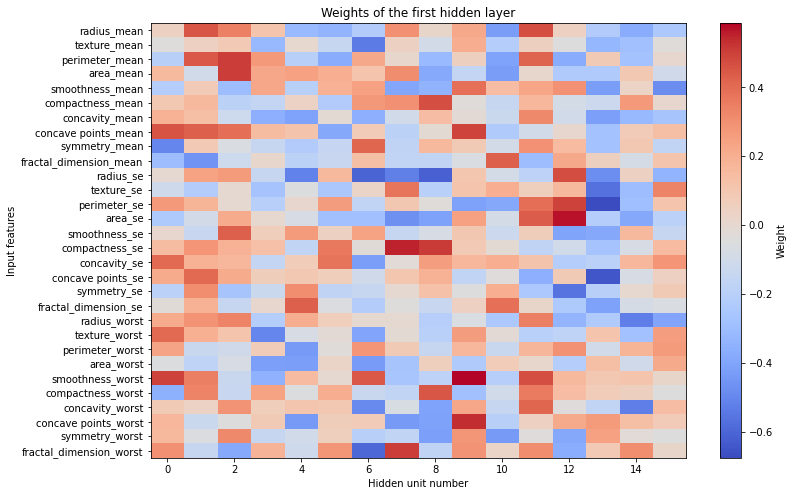

In [27]:
weights = model.coefs_[0]
# print(model.coefs_[0])
# print(weights.shape)
plt.figure(figsize=(12, 8))

plt.imshow(weights, cmap='coolwarm', aspect='auto')
plt.colorbar(label = "Weight")
plt.title('Weights of the first hidden layer')
plt.xlabel('Hidden unit number')

#x_lab = [i for i in range(1, 78)]
plt.yticks(range(len(X.columns)), X.columns)
#plt.xticks(range(len(x_lab)), x_lab, rotation=0)
plt.ylabel('Input features')
plt.show()

This heatmap is a plot that shows the weights of the first hidden layer, where each row corresponds to a different input feature, and each column corresponds to a different hidden unit. The color of each element in the plot represents the weight value. This is a cool method of visualizing how the inputs are weighed in the first hidden layer of our model.

# Linear Regression

In the following code block, we performed linear regression between every input variabel and the diagnosis. Considering the `diagnosis` attribute is either a 0 or a 1 makes these plots look a little strange and may subject them to inheritly low accuracy. Nonetheless, linear regression still finds a linear equation that best represents the relationship between these variables. The $R^2$ value of a linear regression plot is a statistical measure that falls between 0 and 1 that indicates how well the regression line fits the observed data. The closer $R^2$ is to 1, the better the regression line fits the data.

In the plot below, the top 5 plots with the highest $R^2$ values are highlighted in green

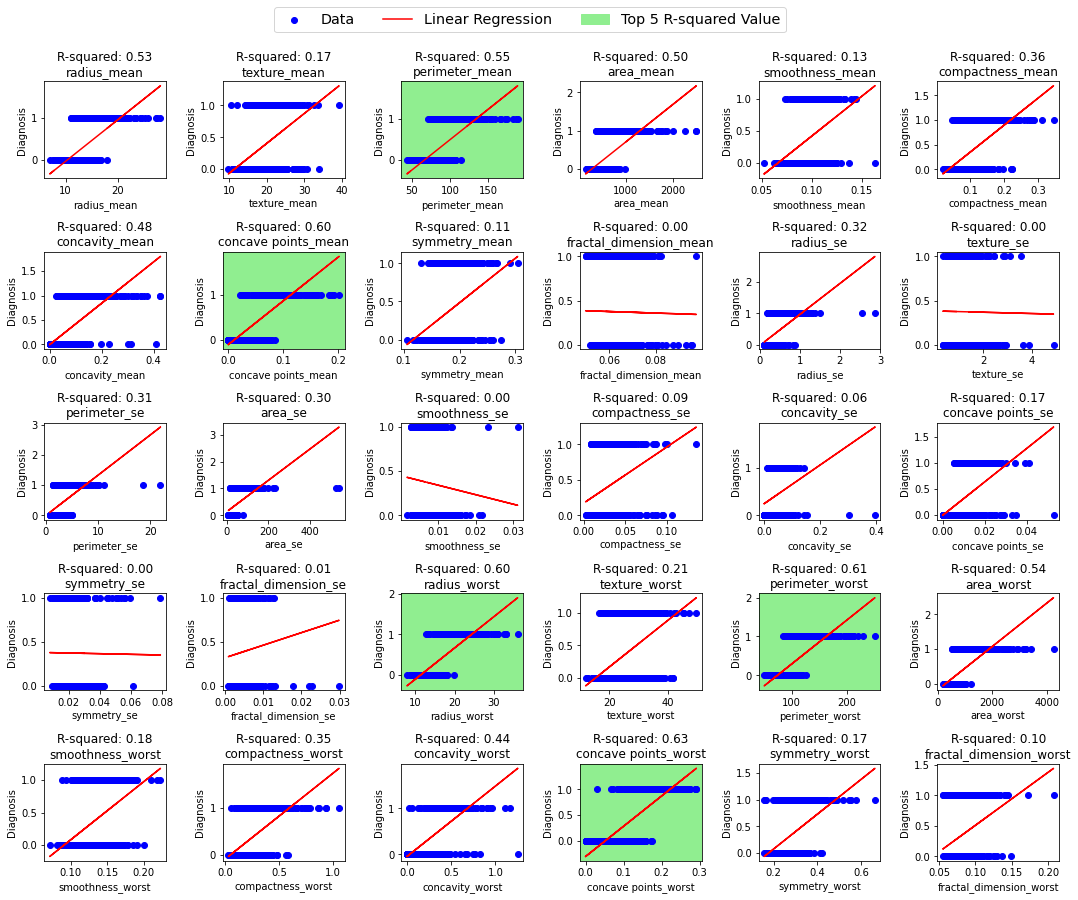

In [28]:

# Assuming you have X as the independent variables DataFrame and y as the dependent variable array

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(15, 12))

lac = []

# Initialize variables to track the top 5 R-squared values and their corresponding subplots
top_r2_values = []
top_r2_subplots = []
# Iterate through the attributes and plot scatter plots
for i, attribute in enumerate(X.columns):
    row = i // 6  # Calculate the row index
    col = i % 6   # Calculate the column index
    
    x = np.array(X[attribute]).reshape(-1, 1)
    y = np.array(y)
    
    regression_model = LinearRegression()
    regression_model.fit(x, y)
    y_pred = regression_model.predict(x)
    
    r2 = r2_score(y, y_pred)
    
    ax = axes[row, col]
    ax.scatter(x, y, color='blue', label='Data')
    ax.plot(x, y_pred, color='red', label='Linear Regression')
    ax.set_xlabel(attribute)
    ax.set_ylabel('Diagnosis')
    ax.set_title(f'R-squared: {r2:.2f}\n{attribute}')
    
    # Update the top 5 R-squared values and their corresponding subplots
    if len(top_r2_values) < 5 or r2 > min(top_r2_values):
        if len(top_r2_values) == 5:
            # Remove the subplot with the lowest R-squared value from the top 5
            index = top_r2_values.index(min(top_r2_values))
            top_r2_values.pop(index)
            top_r2_subplots.pop(index)
        top_r2_values.append(r2)
        top_r2_subplots.append(ax)
    

# Highlight the subplots with the top 5 R-squared values
for subplot in top_r2_subplots:
    subplot.set_facecolor('lightgreen')

# Create a single legend for all the plots
handles, labels = top_r2_subplots[0].get_legend_handles_labels()
handles.append(Patch(facecolor='lightgreen', edgecolor='lightgreen'))
labels.append('Top 5 R-squared Value')
fig.legend(handles, labels, loc='lower center', ncol=3,bbox_to_anchor=(0.5, 1), fontsize="x-large")

# Adjust the spacing between subplots
fig.tight_layout()
# Display the plot
plt.show()


Based on the plots above, we see that the attributes `'perimeter_mean','concave points_mean', 'radius_worst', 'perimeter_worst', 'concave points_worst'` are the top 5 attributes with the highest $R^2$ values, thus have the strongest correlation with predicting the diagnosis. Knowing this, we should try to build a model with just these values and see how accurate it is.

# Top 5 Attributes Model
Below is code for the training of a model with only `'perimeter_mean','concave points_mean', 'radius_worst', 'perimeter_worst', 'concave points_worst'` as inputs. Note that this mlp has different hyper parameters than the previous mlp with 30 inputs.

As you can see from the loss curve above, with these 5 inputs we can acheive 98.24% accuracy which is only ~.6% lower than our model with 30 inputs. This suggests that the other 25 attributes are not that important to the predictions made by the other model.

##### Why is this important?
Knowing that with 5 measurements we can predict the diagnosis of a cancer cell with approximately the same accuracy as with 30 measurements, calculating the measurements of all 30 attributes could be a waiste of both time and money in the medical industry. 

Measuring 5 attributes of a cells dimentions is much simplier that measuing 30, however there is still some problems with this. Measuring 1 attributes can give you information about other attrtibutes. For example, when calculating the perimeter_mean, one can also calcualte the peremeter_worst. Now, lets look at the "categories" that these "top 5" inputs fall into.

| radius attributes  | perimeter attributes  | concave attributes |
| --------- | --------- | --------- |
| radius_worst    | perimeter_worst   | concave points_worst    |
|   | perimeter_mean    | concave points_mean    |


The categories most represented are the perimeter attributes and concave attributes. Seeing that perimeter statistics and concave statistics are in the top5 twice. Lets build a model that only takes the attributes that deal with the perimeter and concavity and see how it impacts our accuracy


# Perimeter and Concave

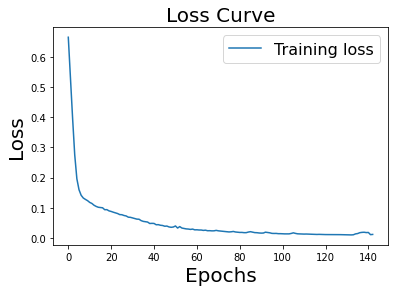

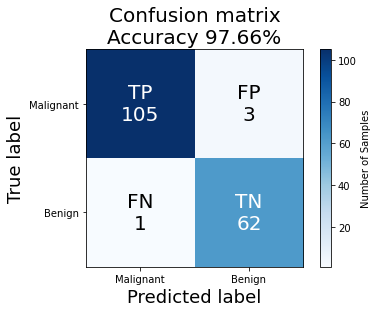

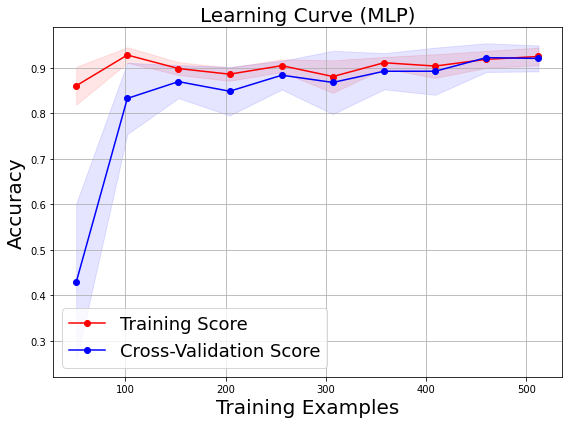

In [29]:
#X_1 = X[['perimeter_mean','concave points_mean', 'perimeter_worst', 'concave points_worst']]
X_pc = X[['concave points_mean', 'concave points_worst', 'concave points_se',
        'perimeter_mean', 'perimeter_worst','perimeter_se']]

X_train_pc, X_test_pc, y_train, y_test = sk.model_selection.train_test_split(X_pc,y, test_size = .3, random_state = random_state)


#Scale the Training and Testing Data
#This scales all of the data to have a standard deviation of 1 and mean 0
#(Standardizes the data so its a Z score)
scaler = StandardScaler()
X_train_pc = scaler.fit_transform(X_train_pc)
X_test_pc = scaler.fit_transform(X_test_pc)


mlp_pc = MLPClassifier(hidden_layer_sizes=(43, 43, 95, 85), max_iter=1000, activation='relu',
                    solver='adam', batch_size = 64, random_state = random_state)

# Train the MLP using the input and output datasets
model_pc = mlp_pc.fit(X_train_pc, y_train)

# Plot the training and validation loss
accuracy_pc = mlp_pc.score(X_test_pc, y_test)

loss_plot_pc = plot_loss_curve(mlp_pc, model_pc)

# Plot Confusion Matrix
y_pred_pc = model_pc.predict(X_test_pc)
cm_pc = confusion_matrix(y_test, y_pred_pc)
cm_plot_pc = plot_confusion_matrix(cm_pc)

# # Plot Learning Curve
learn_plot_pc = plot_learning_curve(model_pc, X_pc, y)

plt.tight_layout()
plt.show()

With only the Perimeter and Concave attributes our accuracy falls from 98.83% too 97.66%. This is not that big a decline, and very impressive considering our first model has 30 inputs and our second model has only 6. Now lets take this one step further, and see how we can do if we only use the Perimeter or Concave statistics.

# Only Perimeter Attributes


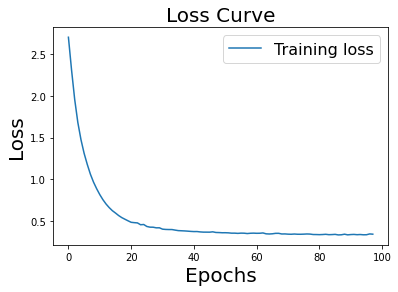

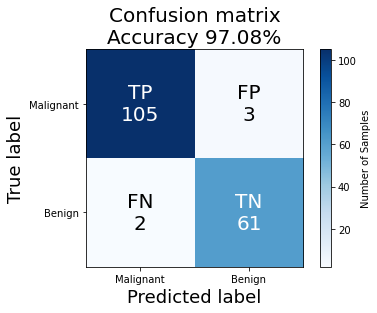

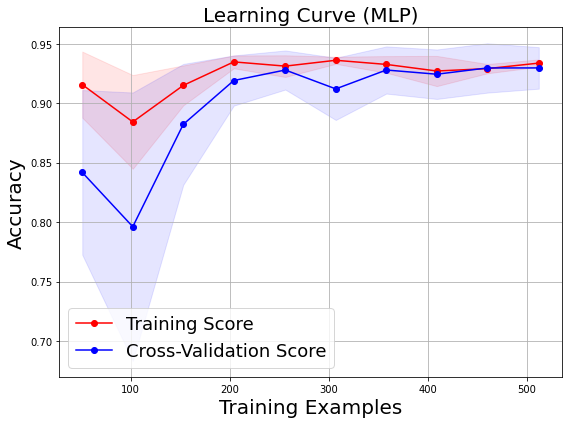

In [30]:

#X_1 = X[['perimeter_mean','concave points_mean', 'perimeter_worst', 'concave points_worst']]
X_p = X[['perimeter_mean', 'perimeter_worst','perimeter_se']]

X_train_p, X_test_p, y_train, y_test = sk.model_selection.train_test_split(X_p,y, test_size = .3, random_state = random_state)


#Scale the Training and Testing Data
#This scales all of the data to have a standard deviation of 1 and mean 0
#(Standardizes the data so its a Z score)
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p)
X_test_p = scaler.fit_transform(X_test_p)


#print(new_X_test)
mlp_p = MLPClassifier(hidden_layer_sizes=(32, 28, 80, 86, 20, 30), max_iter=1000, activation='relu',
                    solver='adam', batch_size = 32, random_state = random_state, alpha = .6)

# Train the MLP using the input and output datasets
model_p = mlp_p.fit(X_train_p, y_train)

accuracy_p = mlp_p.score(X_test_p, y_test)

loss_plot_p = plot_loss_curve(mlp_p, model_p)

# Plot Confusion Matrix
y_pred_p = model_p.predict(X_test_p)
cm_p = confusion_matrix(y_test, y_pred_p)
cm_plot_p = plot_confusion_matrix(cm_p)

# # Plot Learning Curve
learn_plot_p = plot_learning_curve(model_p, X_p, y)

plt.tight_layout()
plt.show()


With Only the Perimeter attributes, we were able to make a model that acheives 97.07% accuracy which is only ~1.8% difference from our model with 30 inputs. This is important because it shows that predicting the data with 3 inputs is nearly as accurate as predicting it with 30 inputs! This model with only 3 inputs is just as accurate as the previous works SVM model with 30 inputs! 

This suggests that if measurement costs of cells are high or time consuming, it may be benificial to make the trade off between accuracy and gathering measurement statistics, as gathering only perimeter measurements is likely sufficient. 

# Only Concave Attributes

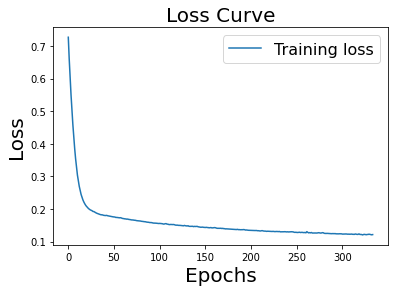

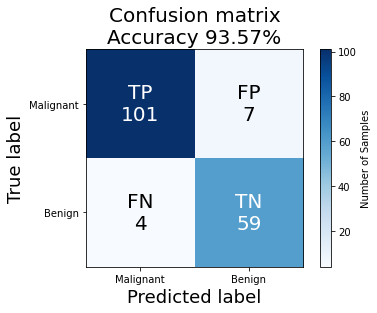

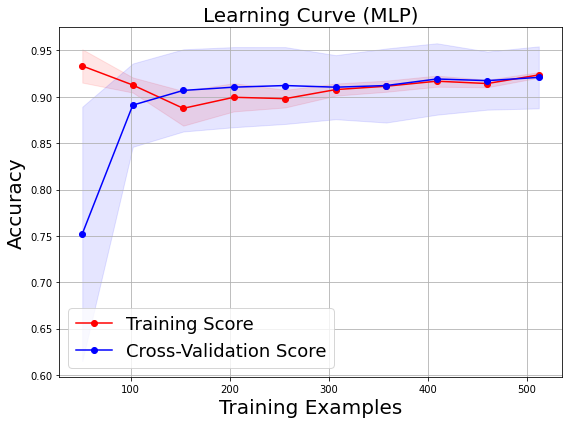

In [31]:

X_c = X[['concave points_mean', 'concave points_worst','concave points_se']]

X_train_c, X_test_c, y_train, y_test = sk.model_selection.train_test_split(X_c,y, test_size = .3, random_state = random_state)


#Scale the Training and Testing Data
#This scales all of the data to have a standard deviation of 1 and mean 0
#(Standardizes the data so its a Z score)
scaler = StandardScaler()
X_train_c = scaler.fit_transform(X_train_c)
X_test_c = scaler.fit_transform(X_test_c)



mlp_c = MLPClassifier(hidden_layer_sizes=(21, 51), max_iter=1000, activation='relu',
                solver='adam', batch_size = 64, random_state = random_state)

# Train the MLP using the input and output datasets
model_c = mlp_c.fit(X_train_c, y_train)



loss_plot_c = plot_loss_curve(mlp_c, model_c)

# Plot Confusion Matrix
y_pred_c = model_c.predict(X_test_c)
cm_c = confusion_matrix(y_test, y_pred_c)
cm_plot_c = plot_confusion_matrix(cm_c)

# # Plot Learning Curve
learn_plot_c = plot_learning_curve(model_c, X_c, y)

plt.tight_layout()
plt.show()


With only the Concave attributes, we were able to make a model that acheives 93.5% accuracy which is a large decline from our original model and perimeter only model. This suggests that the measurements of concave attributes is not sufficient to classify the malignancy of a cell.

# Conclusion



In the end here are the results of each model.


| End Results           | All input MLP || Perimeter & Concave | Perimeter | Concave | 
|-----------------------|---------------|-------|---------------------|-----------|---------|
| Accuracy %            | 98.83         | | 97.66               | 97.07     | 93.57   |
| Inputs                | 30            |      | 6                   | 3         | 3       |  
| Measurements Categories | 10          |    | 2                     | 1         | 1       |     


